In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [2]:
from skimage.feature import local_binary_pattern
def lbp_histogram(image, radius, bins):
    # compute the LBP histogram of the image
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp, bins= bins, density=True)
    return np.ravel(hist)

In [3]:
IMAGE_START = 64
AXIS_ZERO = 121

model_name = "svm_model_layer_classifier.joblib"
model = joblib.load(model_name)
image_path = "../data_preprocessing/processed/WLT_350_210926 P_2111131 WLT_350_210926__008 P_2111131_processed.JPG"

sliding_window_size = 200
step = 40
img = cv2.imread(image_path)

radius = 1
bins = 16

number_image = 0
for j in range(AXIS_ZERO, img.shape[0], step):
    for i in range(IMAGE_START, img.shape[1], step):
        number_image += 1
features=np.zeros(shape=(number_image, bins))

c:\Python310\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
count = 0
for j in range(AXIS_ZERO, img.shape[0], step):
    for i in range(IMAGE_START, img.shape[1], step):
        sliding_window = [i, j, i + sliding_window_size, j + sliding_window_size]
        cropped = img[sliding_window[1]:sliding_window[3], sliding_window[0]:sliding_window[2]]
        rgb_weights = [0.2989, 0.5870, 0.1140]
        cropped = np.dot(cropped[...,:3], rgb_weights)
        cropped = np.array(cropped).astype(np.uint8)
        features[count, :bins] = lbp_histogram(cropped, radius, bins)
        count += 1

In [5]:
# normalize lbp
for i in range(number_image):
    norm = np.linalg.norm(features[i, :bins])
    for j in range(bins):
        features[i, j] = features[i, j] / norm
validate_result = model.predict(features)

print(features.shape)
print(validate_result.shape)

(1680, 16)
(1680,)


In [6]:
height = (img.shape[0] - AXIS_ZERO) // step + 1
width = (img.shape[1] - IMAGE_START) // step + 1
voting = np.zeros((height + 4, width + 4))
total = np.zeros((height + 4, width + 4))

for j in range(height):
    for i in range(width):
        if validate_result[i + j * width] == 1:
            voting[j : j + 5, i : i + 5] += np.ones((5, 5))
        total[j : j + 5, i : i + 5] += np.ones((5, 5))

voting /= total
voting = np.where(voting > 0.5, 1, 0)

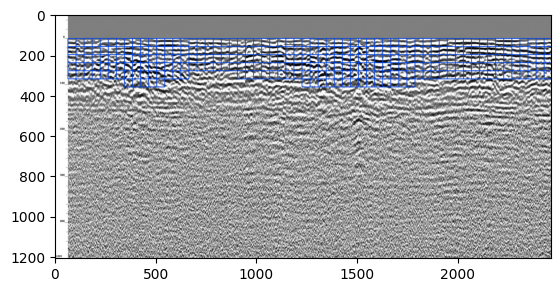

In [7]:
labeled = []
for j in range(height):
    for i in range(width):
        sliding_window = [IMAGE_START + i * step, AXIS_ZERO + j * step, IMAGE_START + (i + 1) * step, AXIS_ZERO + (j + 1) * step]
        if voting[j, i] == 1:
            labeled.append(sliding_window)

color = np.array([3, 67, 223])
box_width = 2
for box in labeled:
    img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * color
    img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * color
    img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * color
    img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * color
plt.imshow(img)
plt.imsave('output.jpg', img)